### NN Model For Line Properties

Author: Jerry Chen

General Overview:

Input Parameters In Order
* ~~Flowrate - Q (uL/min)~~
* ~~Gantry Travel speed - V<sub>g</sub> (mm/min)~~
* LDR - Q/V<sub>g</sub>
* Print Height (mm)

Output Parameters In Order
* Average Width (μm)
* Average Thickness (μm)


In [117]:
# Importing libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transform

import numpy as np

torch.manual_seed(42)

use_cuda = True
device = 'cuda' if torch.cuda.is_available() and use_cuda else 'cpu'

# Class to represent dataset


class lineDataSet():

    def __init__(self):

        # Loading the csv file from the folder path
        # First row is data labels so delete
        data1 = np.loadtxt('cleanlinedata.csv', delimiter=',',
                           dtype=np.float32, skiprows=1)

        # First 4 column are class parameters
        # Only take LDR and print height
        # Last 2 are line properties

        # Zero center input data only
        self.input_mean = np.mean(data1, axis=0)[:4]
        self.x = torch.from_numpy(data1[:, 2:4]-self.input_mean[2:])
        
        self.y = torch.from_numpy(data1[:, 4:])
        self.n_samples = data1.shape[0]

    # support indexing such that dataset[i] can
    # be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


dataset = lineDataSet()

first_data = dataset[0]
parameters, properties = first_data
print(parameters, properties)
# tensor([8.0976e+01, 1.9202e+03, 4.2170e-02, 2.0000e-01]) tensor([364.2700,  78.4050]


tensor([-0.4793, -0.6012]) tensor([364.2700,  78.4050])


In [118]:
#Network model
class Network(nn.Module):
    def __init__(self, channels=1): # default grayscale
        super().__init__()

        self.batch1 = nn.BatchNorm1d(2)
        self.linear1 = nn.Linear(in_features=2, out_features=2) 
        self.linear2 = nn.Linear(in_features=2, out_features=2) 
        self.linear3 = nn.Linear(in_features=2, out_features=2) 
        self.linear4 = nn.Linear(in_features=2, out_features=2) 
        self.linear5 = nn.Linear(in_features=2, out_features=2) 
        self.linear6 = nn.Linear(in_features=2, out_features=2) 
        self.linear7 = nn.Linear(in_features=2, out_features=2) 
        self.out = nn.Linear(in_features=2, out_features=2)

        
    def forward(self, t):
        #t=self.batch1(t)
        t=self.linear1(t)
        t=F.relu(t)    
        t = self.out(t)
        return t

test = Network()

In [119]:
# Training
def train(step_size, batch_size=5, shuffle=False, num_epochs=5):
    # Loading in data
    dataset = lineDataSet()
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size])

    # Data loading - batch_size and shuffle
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle)

    # Compile network, step size
    network = Network()
    if device == "cuda":
        print("Using CUDA")
        network.cuda()
    optimizer = optim.Adam(network.parameters(), lr=step_size)

    # Training
    print('step_size=', step_size, 'batch_size=',
          batch_size, 'shuffle=', shuffle, '\n')
    for epoch in range(num_epochs):
        total_loss = 0

        for batch in train_loader:
            parameters, properties = batch
            if device == "cuda":
                parameters = parameters.cuda()
                properties = properties.cuda()

            preds = network(parameters)

            loss = F.mse_loss(preds, properties)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()*batch_size             # get absolute loss

            # print(preds)
            # print(properties)

        print("epoch", epoch, "\t loss", total_loss)
        print("Prediction: {:.2f} {:.2f} Actual: {:.2f} {:.2f}".format(
            preds[0][0].item(), preds[0][1].item(),
            properties[0][0].item(), properties[0][1].item()))


    return network
lr_list = [0.1, 0.01, 0.001]
batch_size_list = [10, 100, 1000]
shuffle_list = [True, False]

# hyperparameter grid search
# for param in product(lr_list, batch_size_list, shuffle_list):


network=train(0.05,shuffle=True, num_epochs=100)




Using CUDA
step_size= 0.05 batch_size= 5 shuffle= True 

epoch 0 	 loss 56425097.8125
Prediction: 4.56 9.07 Actual: 553.80 258.55
epoch 1 	 loss 53049561.25
Prediction: 42.88 61.32 Actual: 446.69 220.93
epoch 2 	 loss 35266436.40625
Prediction: 615.85 754.33 Actual: 1617.84 752.64
epoch 3 	 loss 9781001.9140625
Prediction: 679.70 502.93 Actual: 835.70 184.78
epoch 4 	 loss 1955163.9331054688
Prediction: 1001.42 421.13 Actual: 1088.69 421.54
epoch 5 	 loss 1224021.6015625
Prediction: 1357.60 505.43 Actual: 1459.48 607.14
epoch 6 	 loss 1123027.8344726562
Prediction: 1222.13 521.28 Actual: 1156.86 621.44
epoch 7 	 loss 1071058.7963867188
Prediction: 1274.71 558.57 Actual: 1571.36 617.28
epoch 8 	 loss 1079161.142578125
Prediction: 1160.52 499.12 Actual: 1205.95 493.49
epoch 9 	 loss 1060446.2390136719
Prediction: 721.37 312.54 Actual: 573.20 258.85
epoch 10 	 loss 1101323.1640625
Prediction: 597.70 251.02 Actual: 446.69 220.93
epoch 11 	 loss 1091657.5170898438
Prediction: 1002.10 428.31

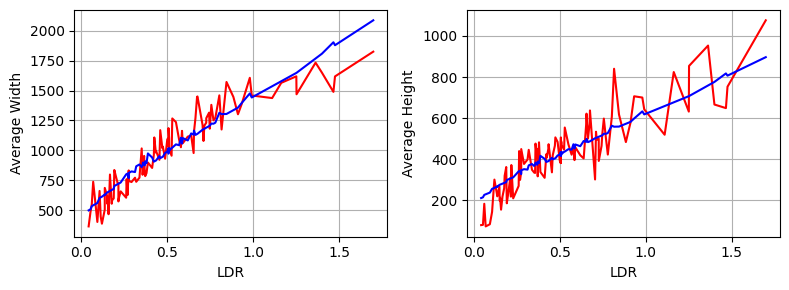

In [120]:
import matplotlib.pylab as plt

dataset = lineDataSet()

with torch.no_grad():
    network = network.cpu()
    pred = network(dataset[:][0])


    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].plot(dataset[:][0][:,0]+dataset.input_mean[2], dataset[:][1][:,0],'r')
    axs[0].plot(dataset[:][0][:,0]+dataset.input_mean[2], pred[:,0],'b')
    axs[0].set_xlabel("LDR")
    axs[0].set_ylabel("Average Width")
    axs[0].grid(True)

    axs[1].plot(dataset[:][0][:,0]+dataset.input_mean[2], dataset[:][1][:,1],'r')
    axs[1].plot(dataset[:][0][:,0]+dataset.input_mean[2], pred[:,1],'b')
    axs[1].set_xlabel("LDR")
    axs[1].set_ylabel("Average Height")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()
# for param in network.parameters():
#    print(param)
